In [ ]:
##@Author: Gemma Gordon
##@Date: July 2022
## Script used to compare the linearity of epitopes across Abs and sdAbs datasets and different binding site definitions

### linear vs discontinuous epitopes in sdabs vs flabs

In [1]:
import pandas as pd 
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
plt.rcParams['figure.dpi'] = 1200

In [3]:
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df

load in summary datasets from epitope length analysis

In [4]:
sdabs_df = read_dataset('gg_sdabs_summary_epitopes.csv')
flabs_df = read_dataset('gg_flabs_summary_epitopes.csv')

In [53]:
sdabs_df.columns

Index(['Unnamed: 0', 'pdb', 'antigen_sequence', 'epitope_dis', 'epitope_arp',
       'epitope_arp_res_nums', 'epitope_arp_seqs', 'epitope_dis_res_nums',
       'epitope_dis_seqs', 'epitope_dis_length', 'epitope_arp_length'],
      dtype='object')

In [54]:
flabs_df.columns

Index(['Unnamed: 0', 'pdb', 'antigen_sequence', 'epitope_dis', 'epitope_arp',
       'epitope_arp_VHVL', 'epitope_dis_VHVL', 'epitope_arp_res_nums_VHVL',
       'epitope_arp_seqs_VHVL', 'epitope_dis_res_nums_VHVL',
       'epitope_dis_seqs_VHVL', 'epitope_dis_length_VHVL',
       'epitope_arp_length_VHVL'],
      dtype='object')

functions to order lists of residue position numbers and generate score for the epitope sequence

In [5]:
def get_res_positions(res_nums_list):

    try:
        positions = sorted(list(res_nums_list))
        positions = [int(p) for p in positions]
    except:
        # if anarci insertion which looks like e.g. 110A, strip letters
        positions = []
        for r in res_nums_list:
            r = ''.join(filter(str.isdigit, r))
            positions.append(r)
        positions = sorted([int(p) for p in positions])
    
    return positions

count how many residues are linear, plot as proportions

In [6]:
def count_linear_residues(positions):
    counter = 0
    score = 0 
    while counter < len(positions)-1:
        if positions[counter] + 1 == positions[counter+1]:
            score += 1
        else:
            score == score
        counter += 1 
    return score

sdAbs

In [7]:
sdabs_scores_percentage = []
sdabs_scores_count = []
for row in sdabs_df['epitope_arp']:
    try:
        positions = get_res_positions(row.keys())
        score = count_linear_residues(positions)
        sdabs_scores_count.append(score)
        # divide by epitope length to normalise ? not convinced this is right way to normalise
        score_percentage = (score / len(positions)) * 100 # just divide score to get proportion of linear residues
        sdabs_scores_percentage.append(score_percentage)
    except:
        pass

flAbs

In [8]:
flabs_scores_percentage = []
flabs_scores_count = []
for row in flabs_df['epitope_arp_VHVL']:
    try:
        positions = get_res_positions(row.keys())
        score = count_linear_residues(positions)
        flabs_scores_count.append(score)
        # divide by epitope length to get percentage
        score_percentage = (score / len(positions)) * 100
        flabs_scores_percentage.append(score_percentage)
    except:
        pass

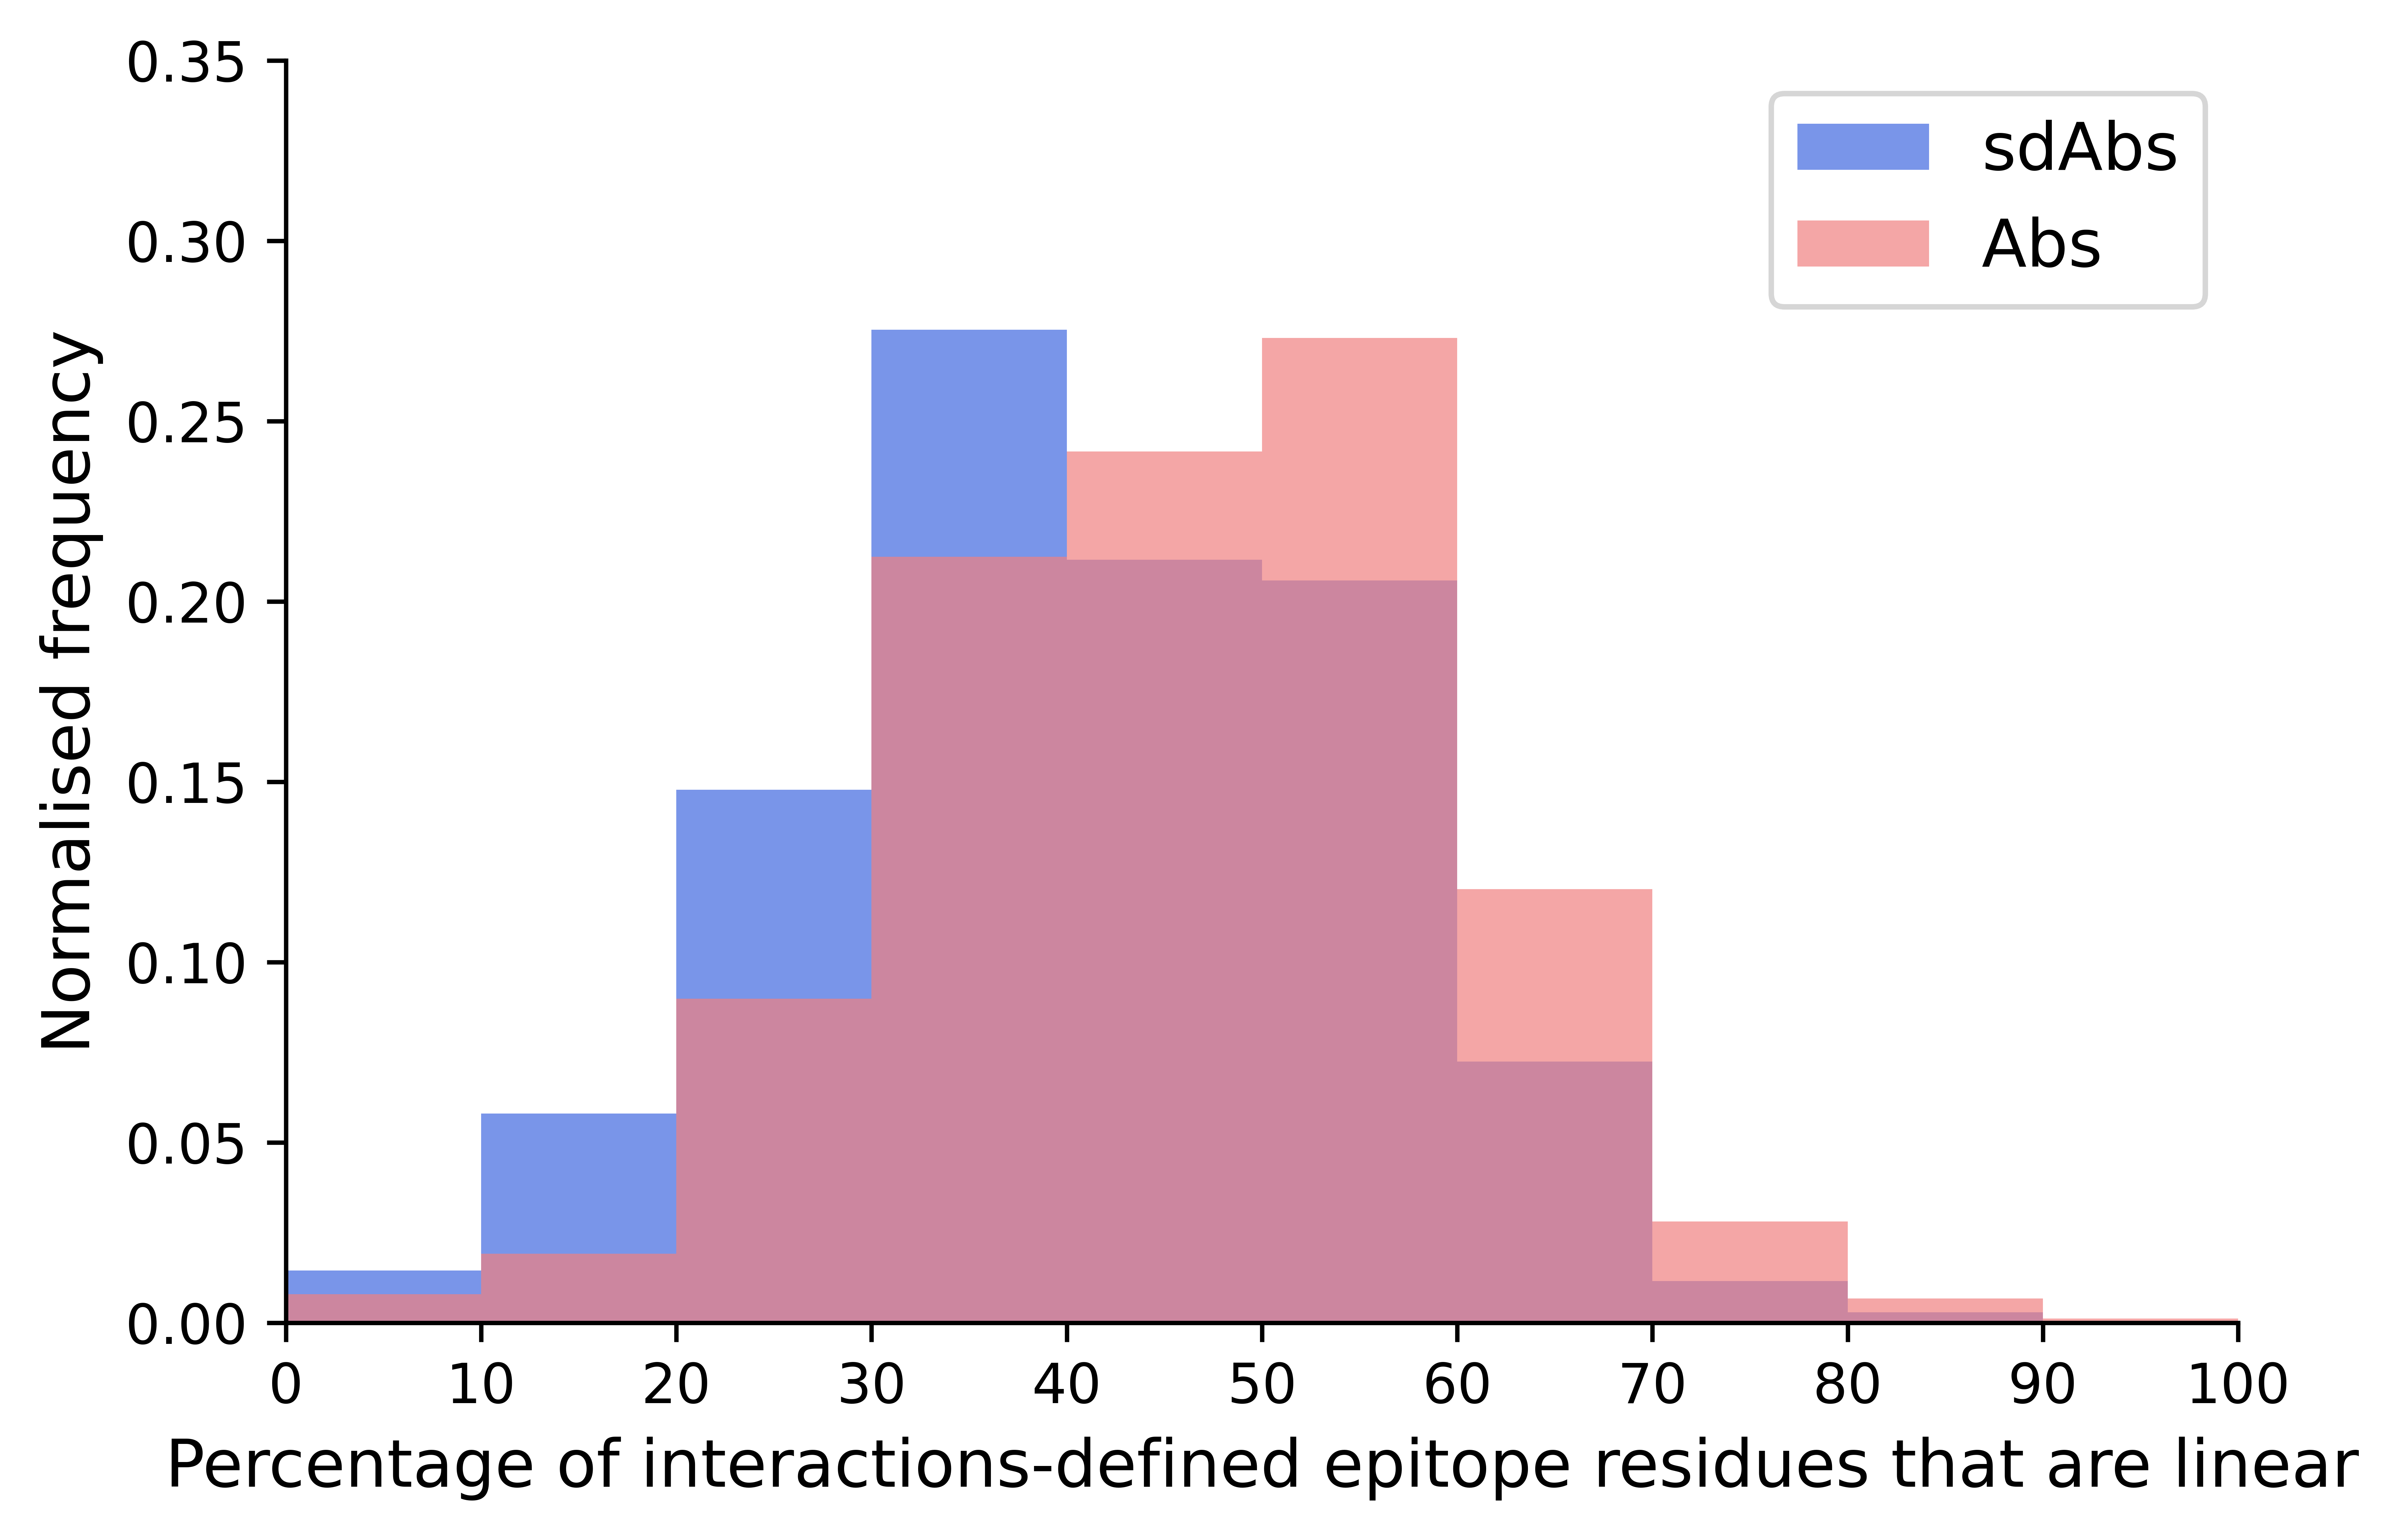

In [9]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure()
plt.hist(sdabs_scores_percentage, bins=bins, label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_percentage) + 1. / len(sdabs_scores_percentage))
plt.hist(flabs_scores_percentage, bins=bins, label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(flabs_scores_percentage) + 1. / len(flabs_scores_percentage))
plt.xlabel('Percentage of interactions-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 100, 10)
plt.xticks(range(0, 110, 10))
plt.ylim(0, 0.35)
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

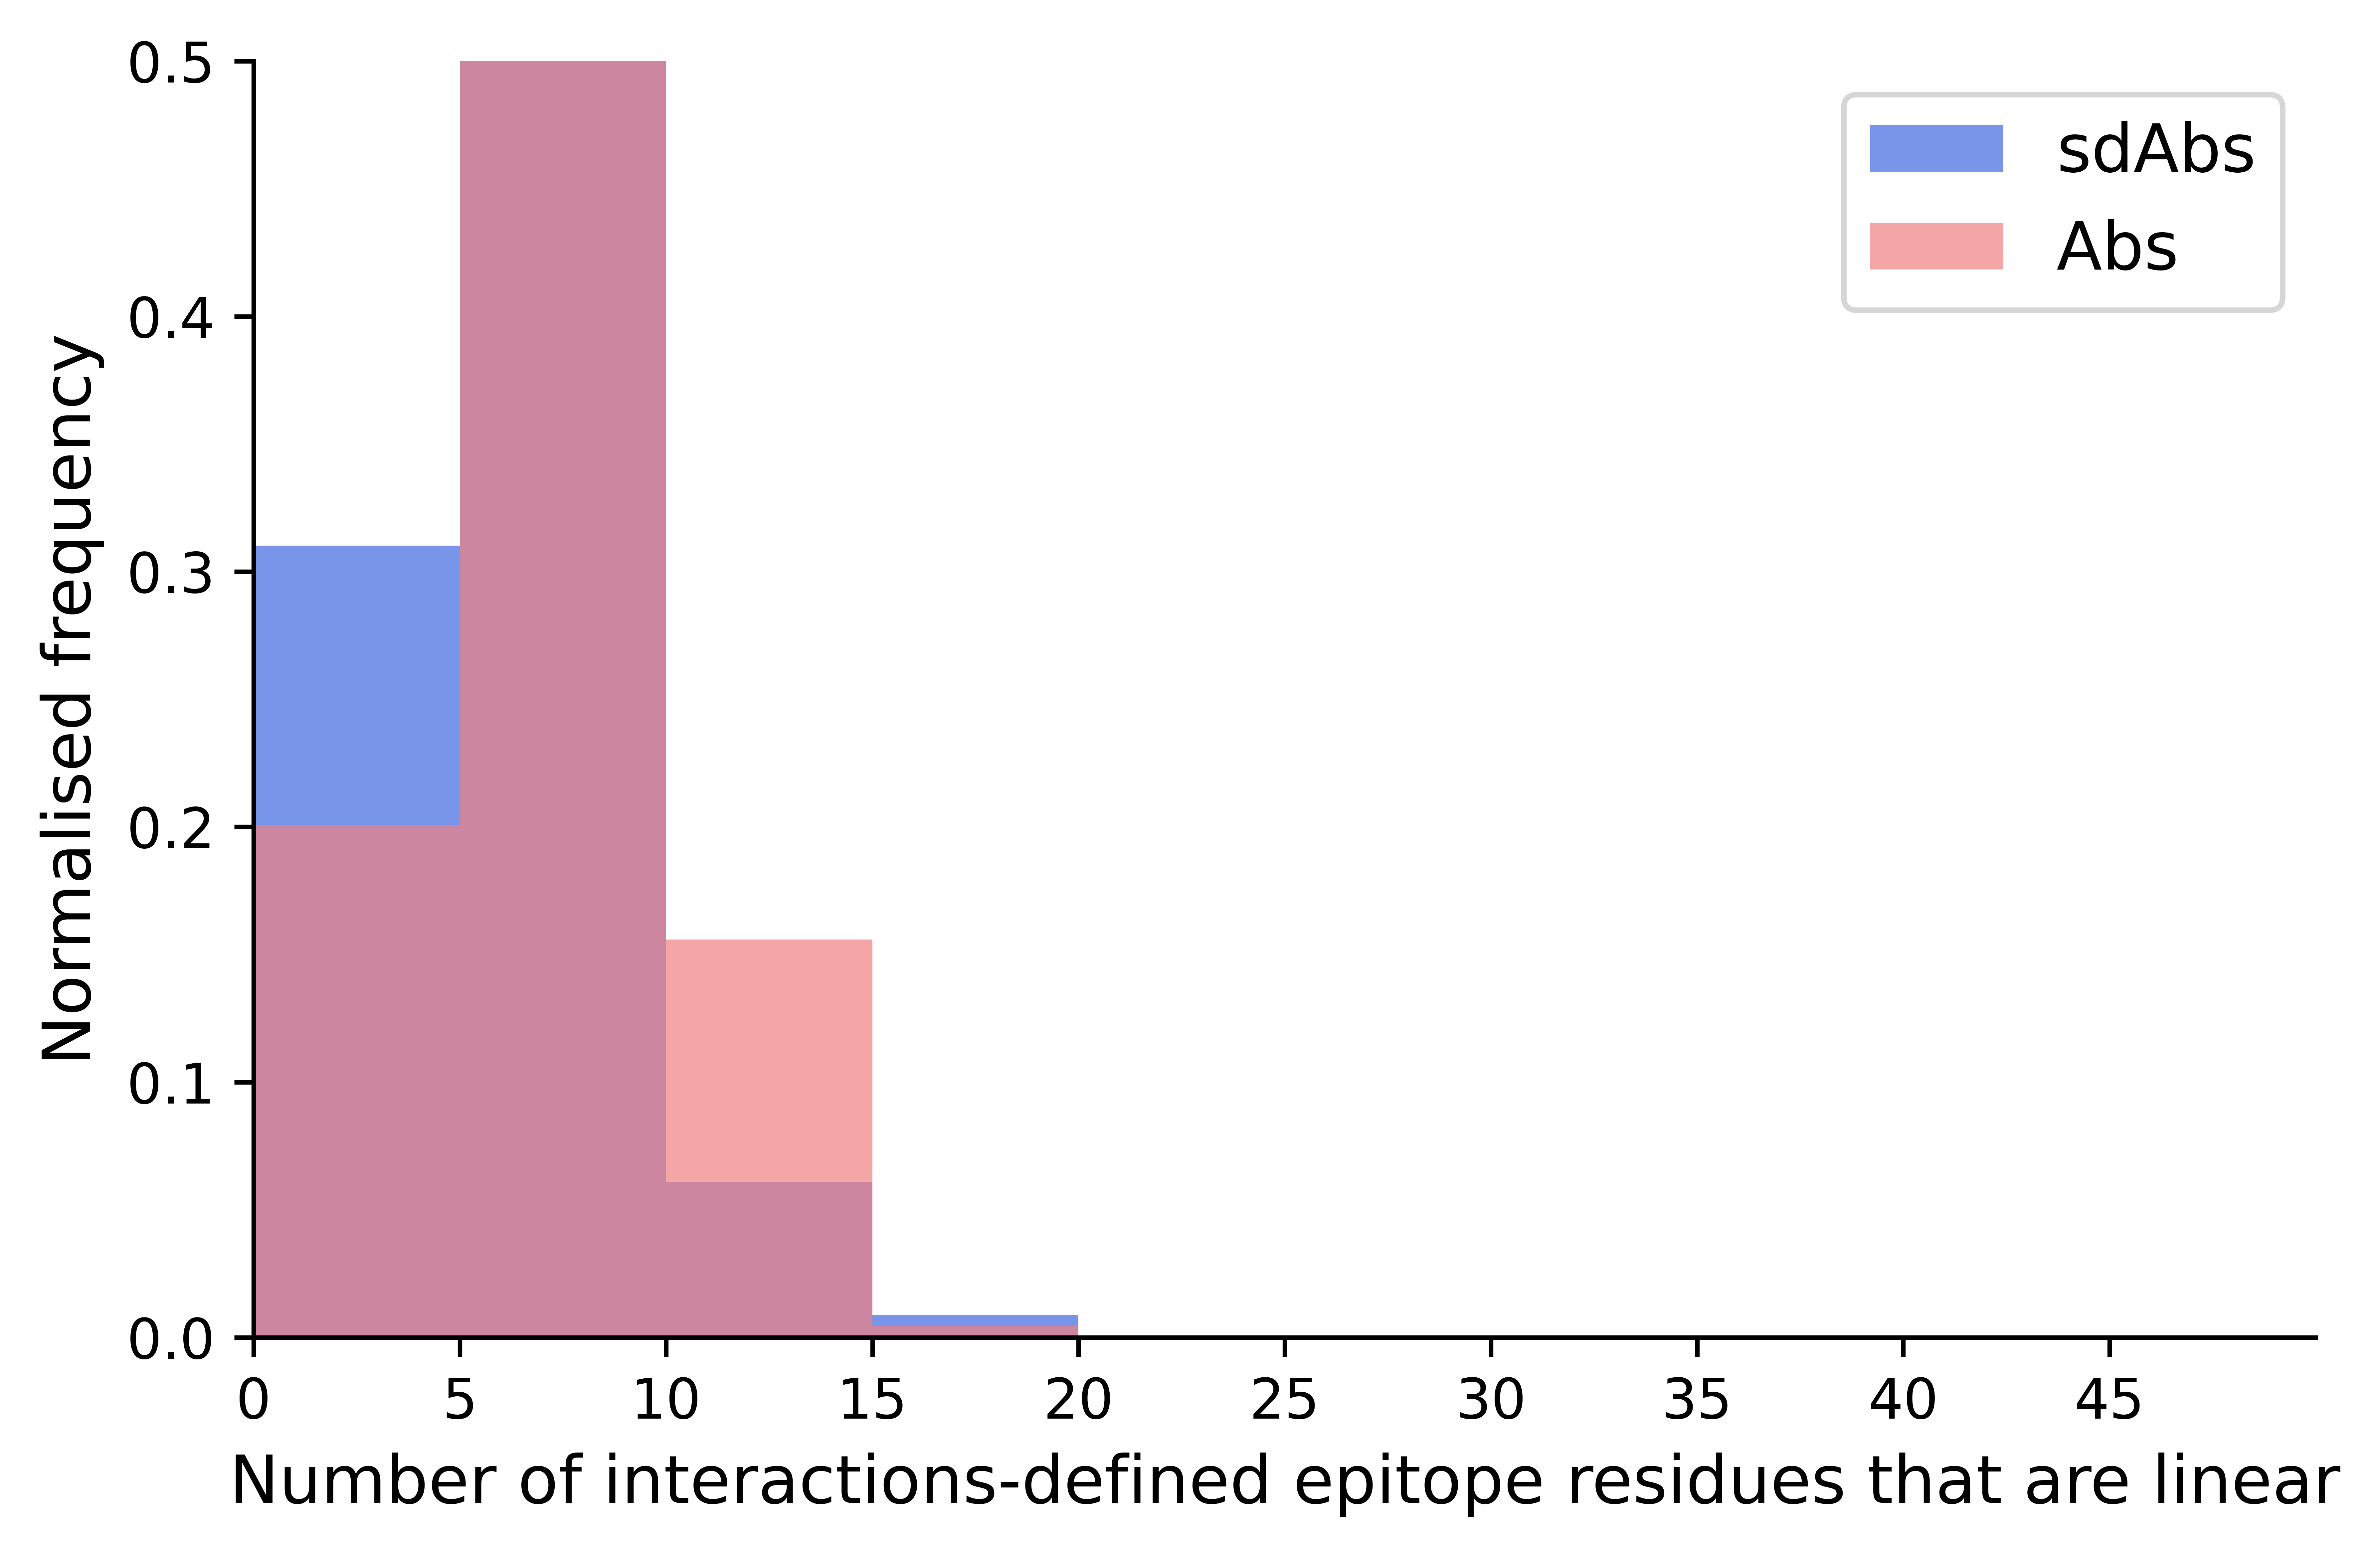

In [10]:
plt.figure()
plt.hist(sdabs_scores_count, bins=range(0, 50, 5), label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_count) + 1. / len(sdabs_scores_count))
plt.hist(flabs_scores_count, bins=range(0, 50, 5), label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(flabs_scores_count) + 1. / len(flabs_scores_count))
plt.xlabel('Number of interactions-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 50, 5)
plt.ylim(0, 0.5)
plt.xticks(range(0, 50, 5))
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Bootstrapping results

In [61]:
import dabest

In [62]:
from statsmodels.stats.weightstats import ztest as ztest

In [63]:
def perform_bootstrap(n_sample, interaction_sizes):
    df = pd.DataFrame([np.random.choice(interaction_sizes[k],n_sample,replace=False) for k in interaction_sizes]).T
    df.columns = [k for k in interaction_sizes]
    x = dabest.load(df, idx=(list(interaction_sizes.keys())[0],list(interaction_sizes.keys())[1]))
    print(x.mean_diff)

In [64]:
zoutput_percentage = ztest(sdabs_scores_percentage, flabs_scores_percentage, value=0) 
print(f"ztest continuity percentage: {zoutput_percentage}")

ztest continuity percentage: (-6.392538820659805, 1.6315378603683978e-10)


In [65]:
dict_lengths_percentage = {'Nbs': sdabs_scores_percentage,
                     'Abs': flabs_scores_percentage }
perform_bootstrap(300, dict_lengths_percentage)

DABEST v0.3.1
             
Good afternoon!
The current time is Mon Apr  3 16:33:13 2023.

The unpaired mean difference between Nbs and Abs is 6.09 [95%CI 3.84, 8.43].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


In [66]:
zoutput_count = ztest(sdabs_scores_count, flabs_scores_count, value=0) 
print(f"ztest continuity count: {zoutput_count}")

ztest continuity count: (-5.026697230719846, 4.989992422692278e-07)


In [67]:
dict_lengths_count = {'Nbs': sdabs_scores_count,
                     'Abs': flabs_scores_count }
perform_bootstrap(300, dict_lengths_count)

DABEST v0.3.1
             
Good afternoon!
The current time is Mon Apr  3 16:33:14 2023.

The unpaired mean difference between Nbs and Abs is 0.883 [95%CI 0.443, 1.34].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


### Do same for distance-defined epitopes

In [11]:
sdabs_scores_percentage = []
sdabs_scores_count = []
for row in sdabs_df['epitope_dis']:
    try:
        positions = get_res_positions(row.keys())
        score = count_linear_residues(positions)
        sdabs_scores_count.append(score)
        # divide by epitope length to normalise ? not convinced this is right way to normalise
        score_percentage = (score / len(positions)) * 100 # just divide score to get proportion of linear residues
        sdabs_scores_percentage.append(score_percentage)
    except:
        pass

In [12]:
flabs_scores_percentage = []
flabs_scores_count = []
for row in flabs_df['epitope_dis_VHVL']:
    try:
        positions = get_res_positions(row.keys())
        score = count_linear_residues(positions)
        flabs_scores_count.append(score)
        # divide by epitope length to get percentage
        score_percentage = (score / len(positions)) * 100
        flabs_scores_percentage.append(score_percentage)
    except:
        pass

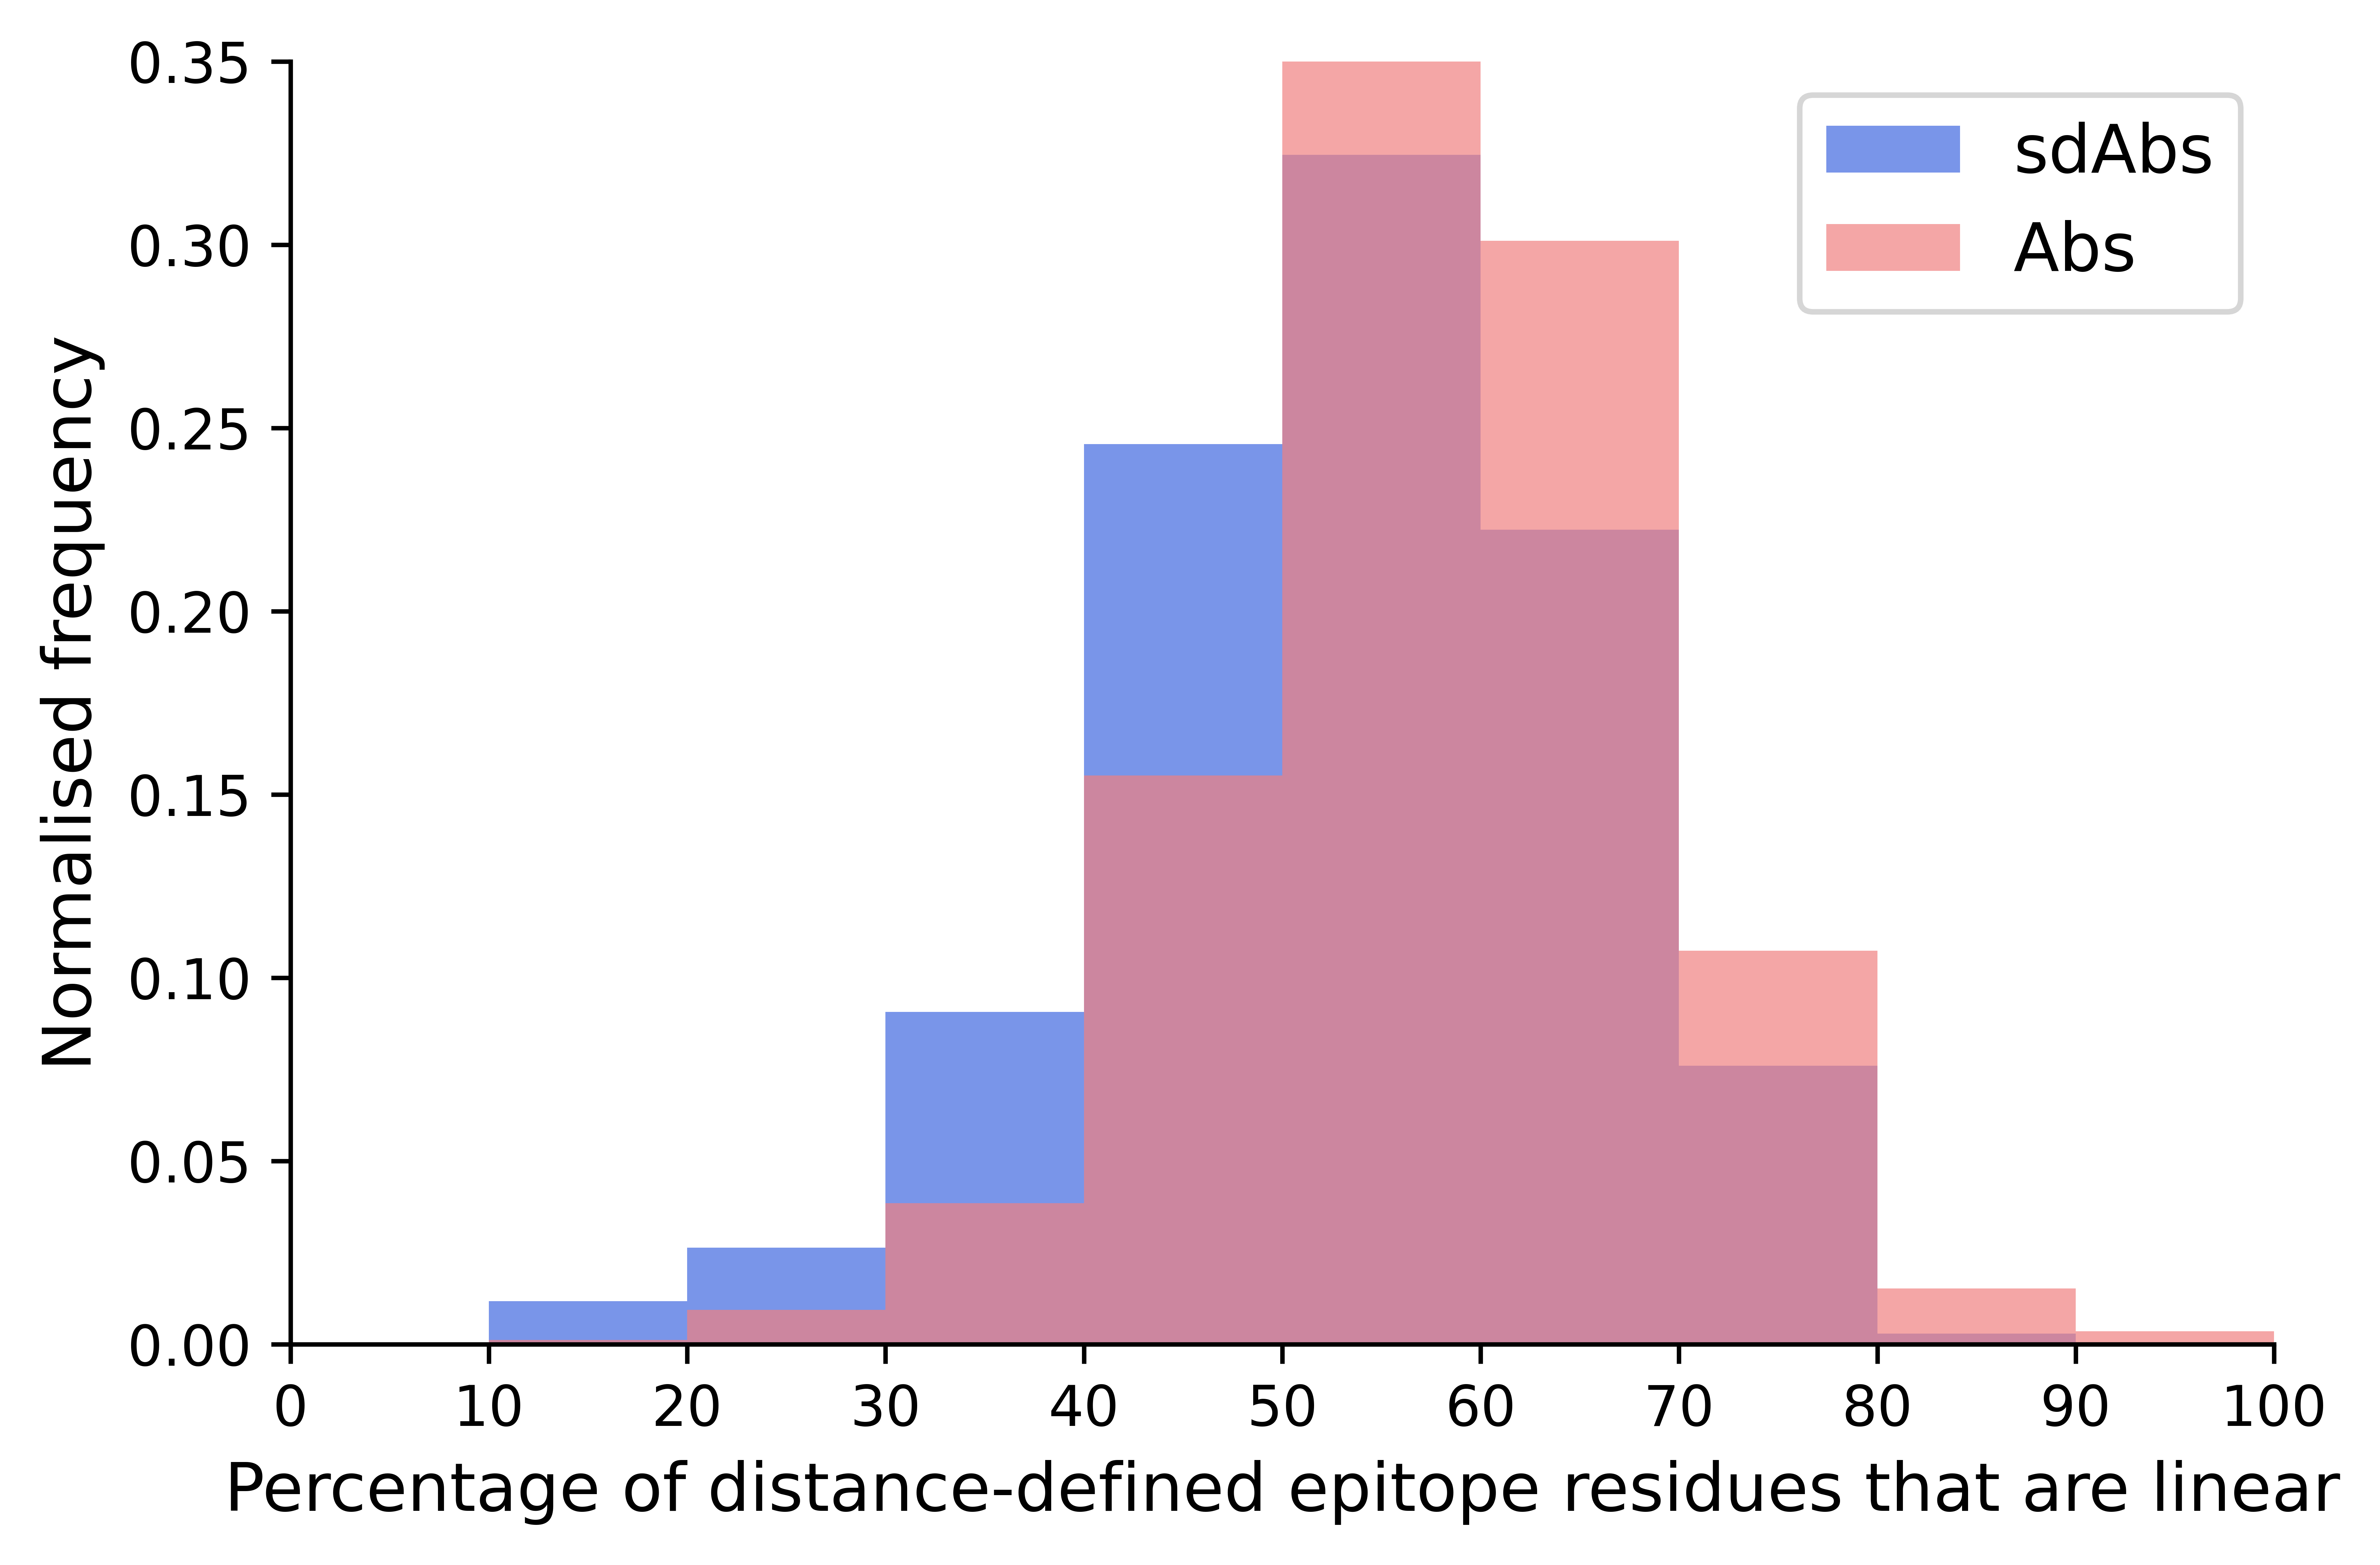

In [13]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure()
plt.hist(sdabs_scores_percentage, bins=bins, label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_percentage) + 1. / len(sdabs_scores_percentage))
plt.hist(flabs_scores_percentage, bins=bins, label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(flabs_scores_percentage) + 1. / len(flabs_scores_percentage))
plt.xlabel('Percentage of distance-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 100, 10)
plt.xticks(range(0, 110, 10))
plt.ylim(0, 0.35)
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [13]:
zoutput_percentage = ztest(sdabs_scores_percentage, flabs_scores_percentage, value=0) 
print(f"ztest continuity percentage: {zoutput_percentage}")
dict_lengths_percentage = {'Nbs': sdabs_scores_percentage,
                     'Abs': flabs_scores_percentage }
perform_bootstrap(300, dict_lengths_percentage)

NameError: name 'ztest' is not defined

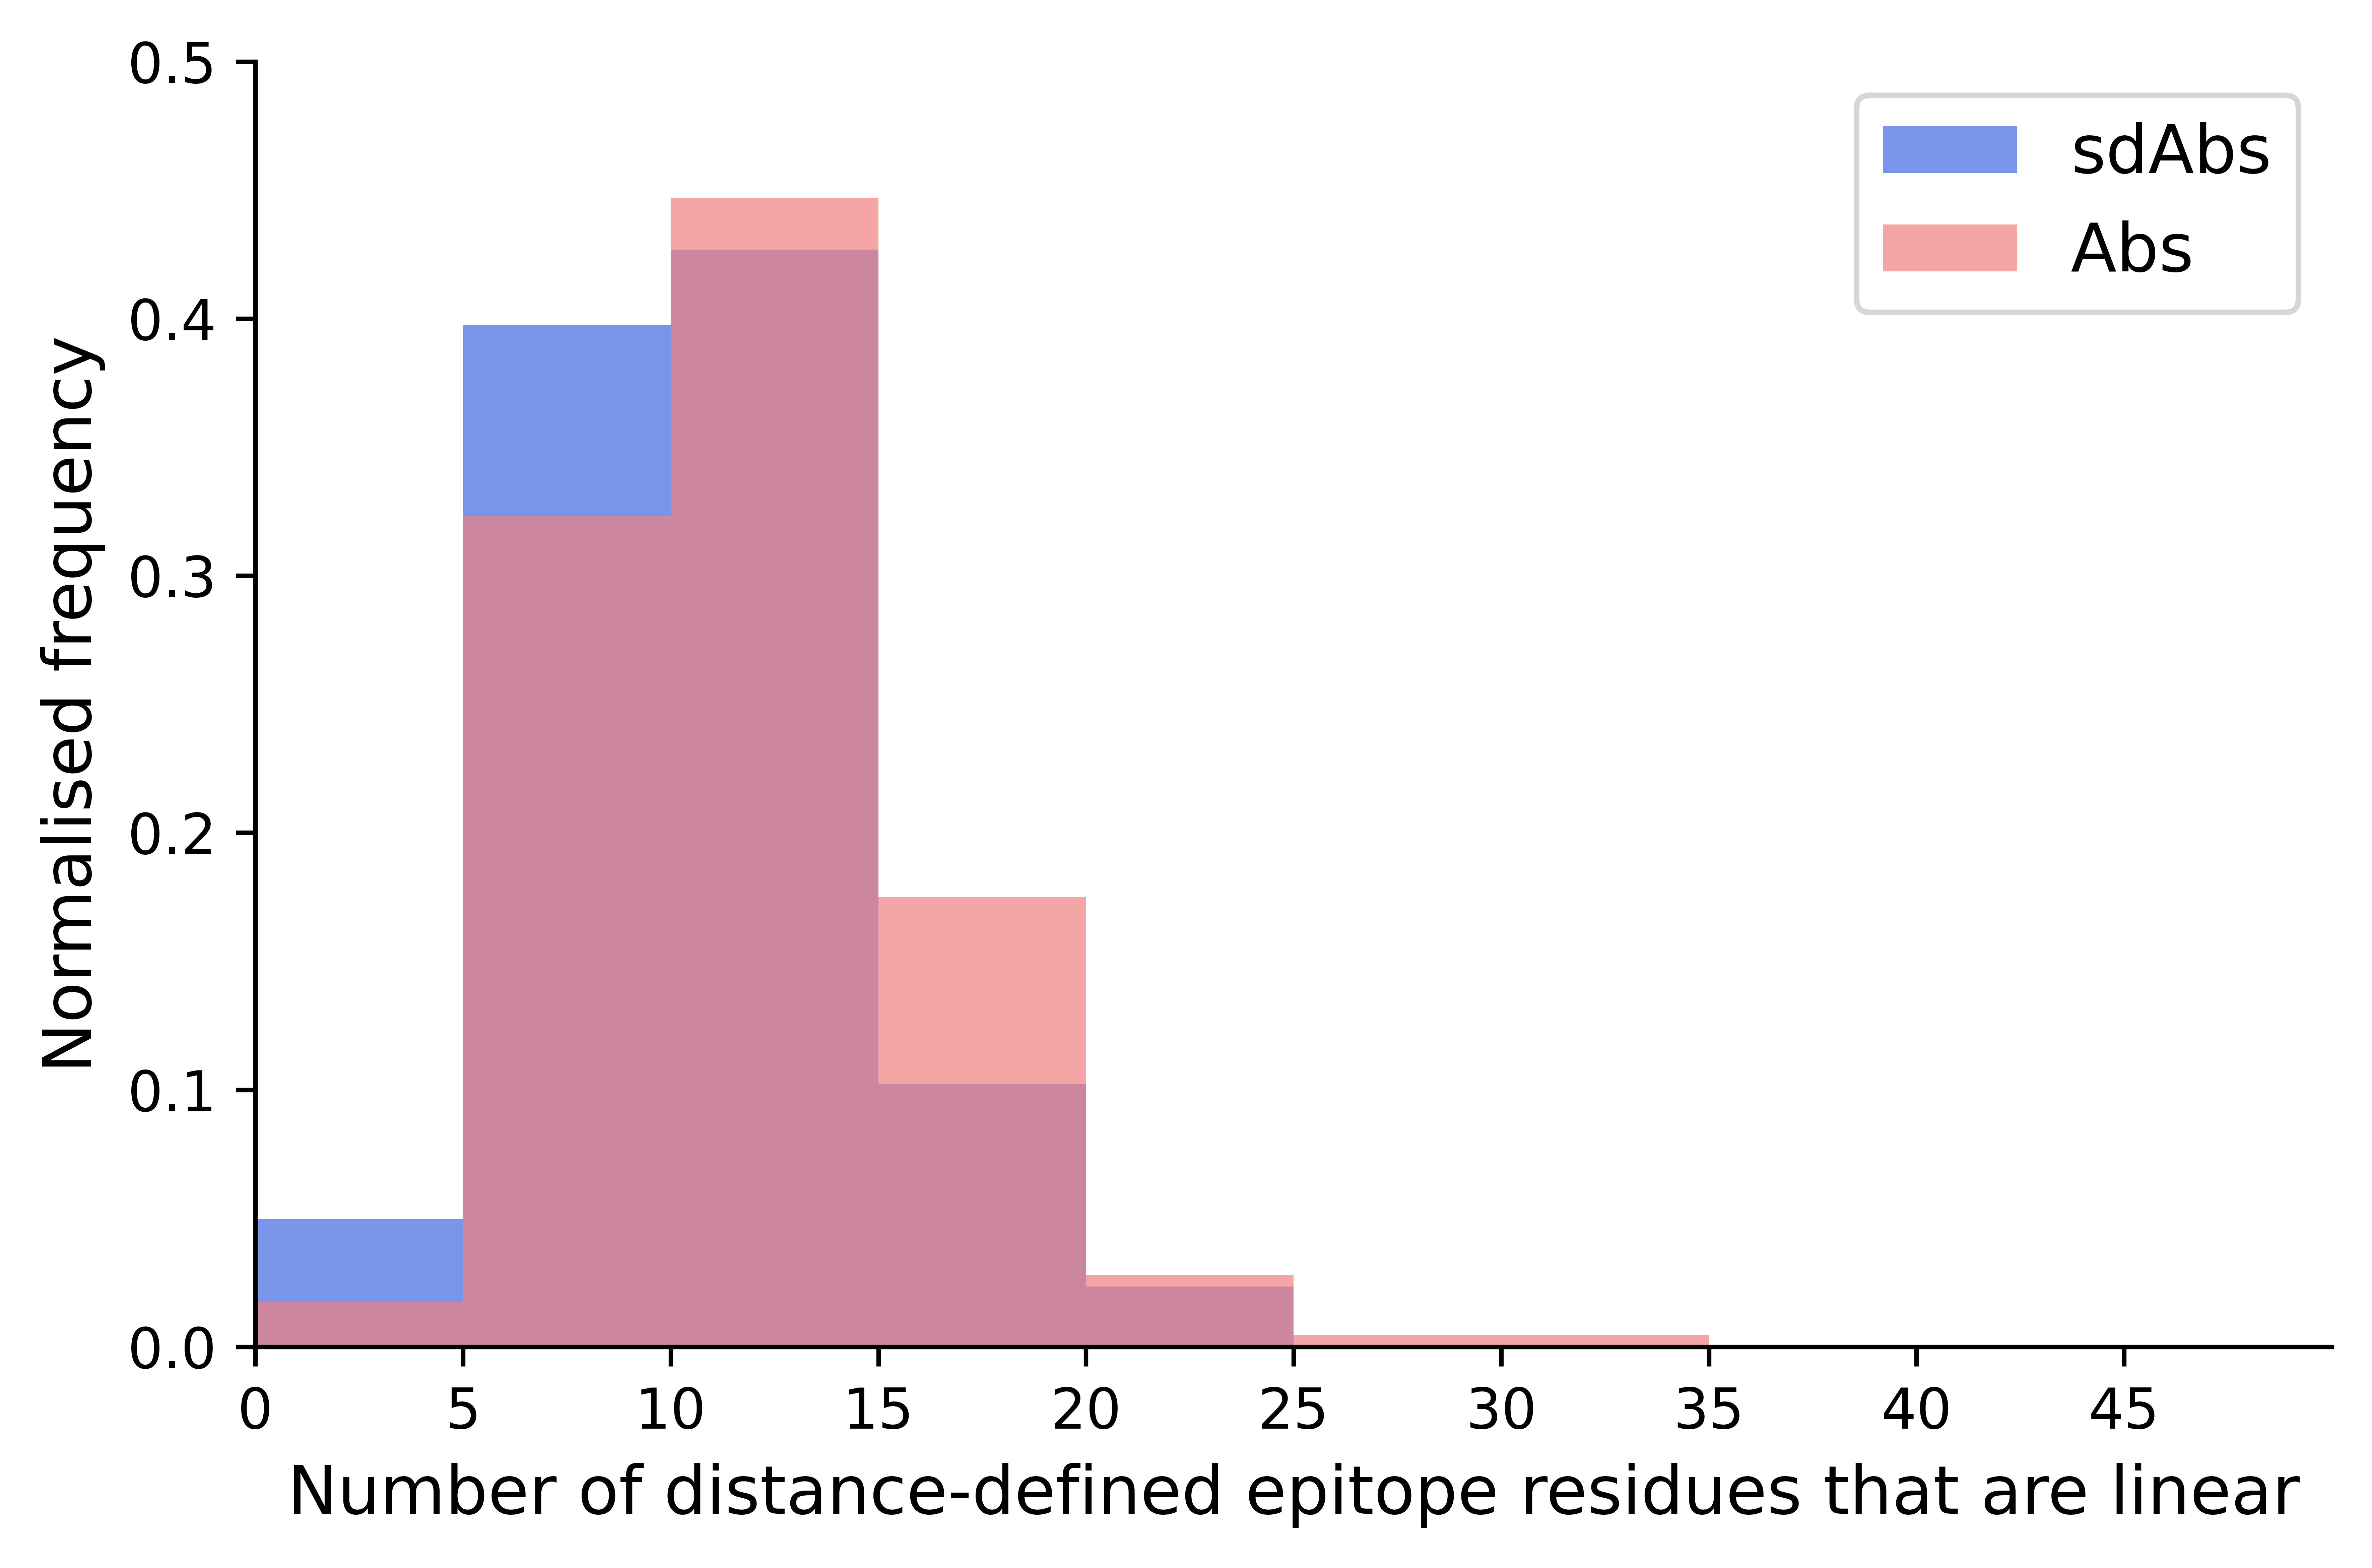

In [14]:
plt.figure()
plt.hist(sdabs_scores_count, bins=range(0, 50, 5), label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_count) + 1. / len(sdabs_scores_count))
plt.hist(flabs_scores_count, bins=range(0, 50, 5), label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(flabs_scores_count) + 1. / len(flabs_scores_count))
plt.xlabel('Number of distance-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 50, 5)
plt.ylim(0, 0.5)
plt.xticks(range(0, 50, 5))
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [73]:
zoutput_count = ztest(sdabs_scores_count, flabs_scores_count, value=0) 
print(f"ztest continuity count: {zoutput_count}")
dict_lengths_count = {'Nbs': sdabs_scores_count,
                     'Abs': flabs_scores_count }
perform_bootstrap(300, dict_lengths_count)

ztest continuity count: (-4.797859740492028, 1.6037001047362116e-06)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon Apr  3 16:33:17 2023.

The unpaired mean difference between Nbs and Abs is 1.39 [95%CI 0.703, 2.04].
The p-value of the two-sided permutation t-test is 0.0004. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


### Do for SASA-defined epitopes

In [15]:
sdabs_df = pd.read_csv('sdAbs_SASA_results_epitope_unique.csv')
abs_df = pd.read_csv('Abs_SASA_results_epitope_unique.csv')

In [16]:
sdabs_scores_percentage = []
sdabs_scores_count = []
for row in sdabs_df['epitope_numbering']:
    row = ast.literal_eval(row)
    try:
        positions = [int(r) for r in row]
        score = count_linear_residues(positions)
        sdabs_scores_count.append(score)
        # divide by epitope length to normalise ? not convinced this is right way to normalise
        score_percentage = (score / len(positions)) * 100 # just divide score to get proportion of linear residues
        sdabs_scores_percentage.append(score_percentage)
    except:
        pass

In [17]:
abs_scores_percentage = []
abs_scores_count = []
for row in abs_df['epitope_numbering']:
    row = ast.literal_eval(row)
    try:
        positions = [int(r) for r in row]
        score = count_linear_residues(positions)
        abs_scores_count.append(score)
        # divide by epitope length to get percentage
        score_percentage = (score / len(positions)) * 100
        abs_scores_percentage.append(score_percentage)
    except:
        pass

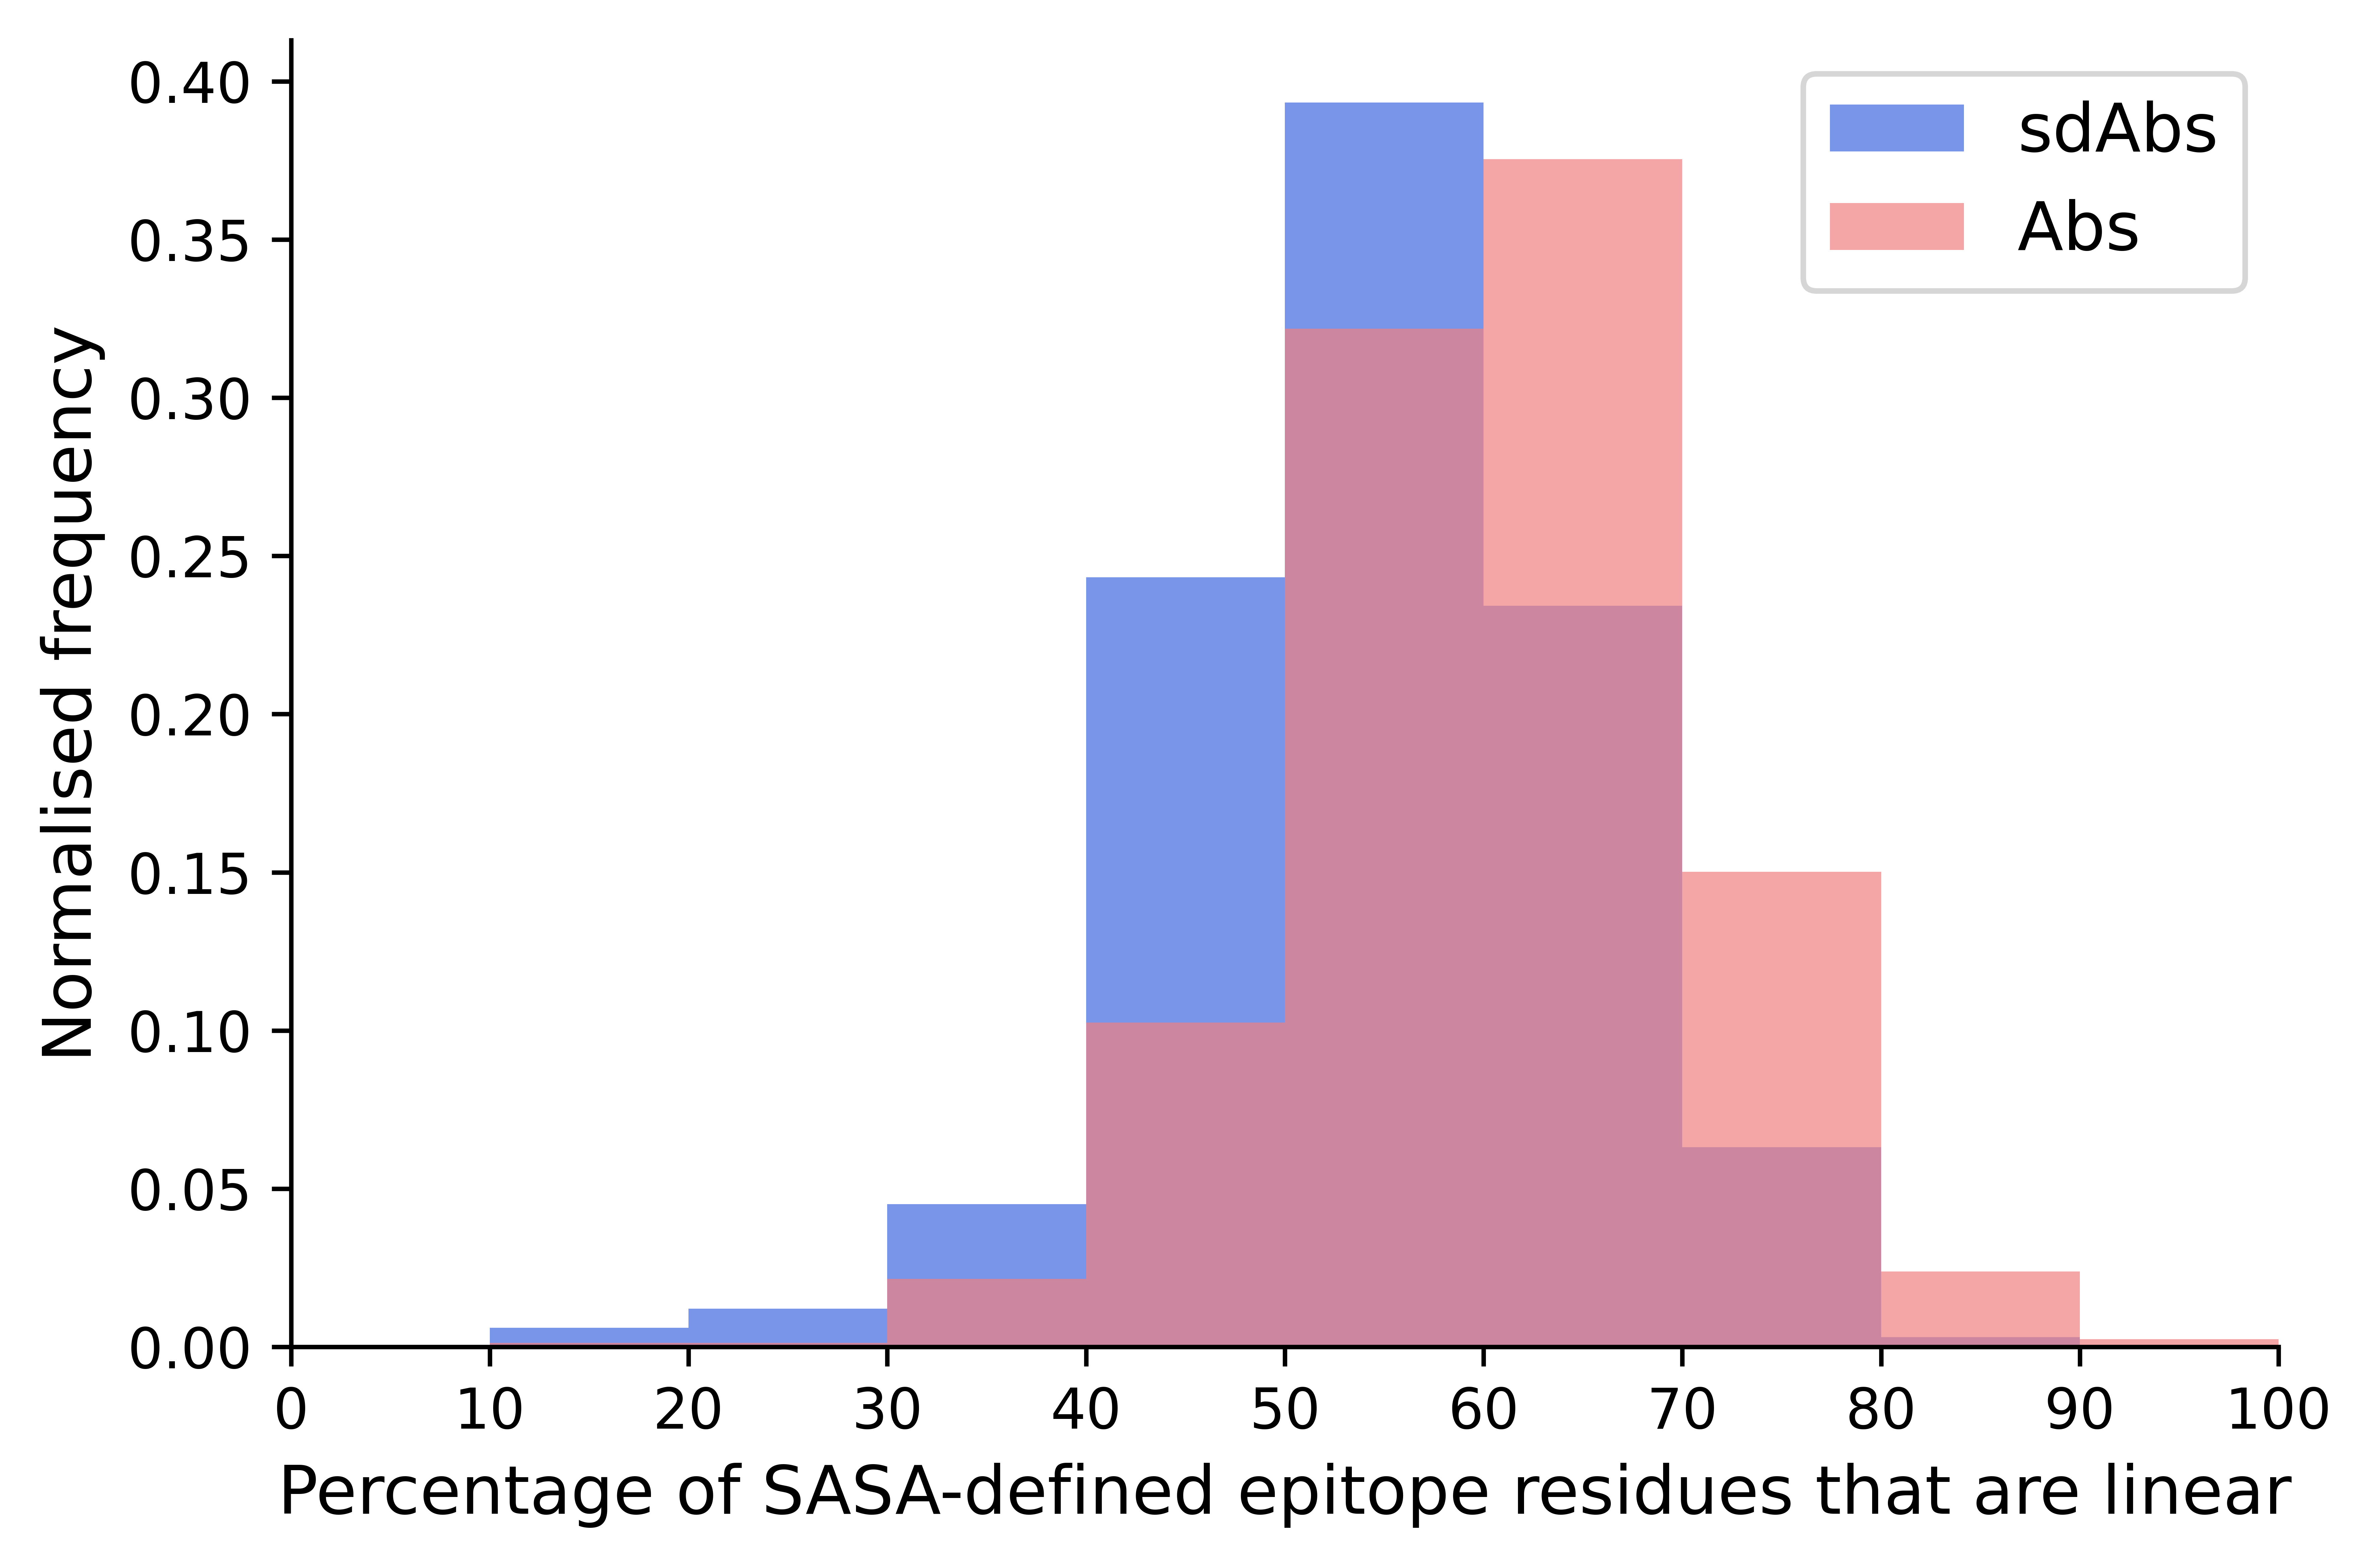

In [18]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure()
plt.hist(sdabs_scores_percentage, bins=bins, label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_percentage) + 1. / len(sdabs_scores_percentage))
plt.hist(abs_scores_percentage, bins=bins, label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(abs_scores_percentage) + 1. / len(abs_scores_percentage))
plt.xlabel('Percentage of SASA-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 100, 10)
plt.xticks(range(0, 110, 10))
#plt.ylim(0, 0.35)
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [78]:
zoutput_percentage = ztest(sdabs_scores_percentage, abs_scores_percentage, value=0) 
print(f"ztest continuity percentage: {zoutput_percentage}")
dict_lengths_percentage = {'Nbs': sdabs_scores_percentage,
                     'Abs': abs_scores_percentage }
perform_bootstrap(300, dict_lengths_percentage)

ztest continuity percentage: (-9.243633242950816, 2.382662146039277e-20)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon Apr  3 16:33:21 2023.

The unpaired mean difference between Nbs and Abs is 6.34 [95%CI 4.68, 8.01].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


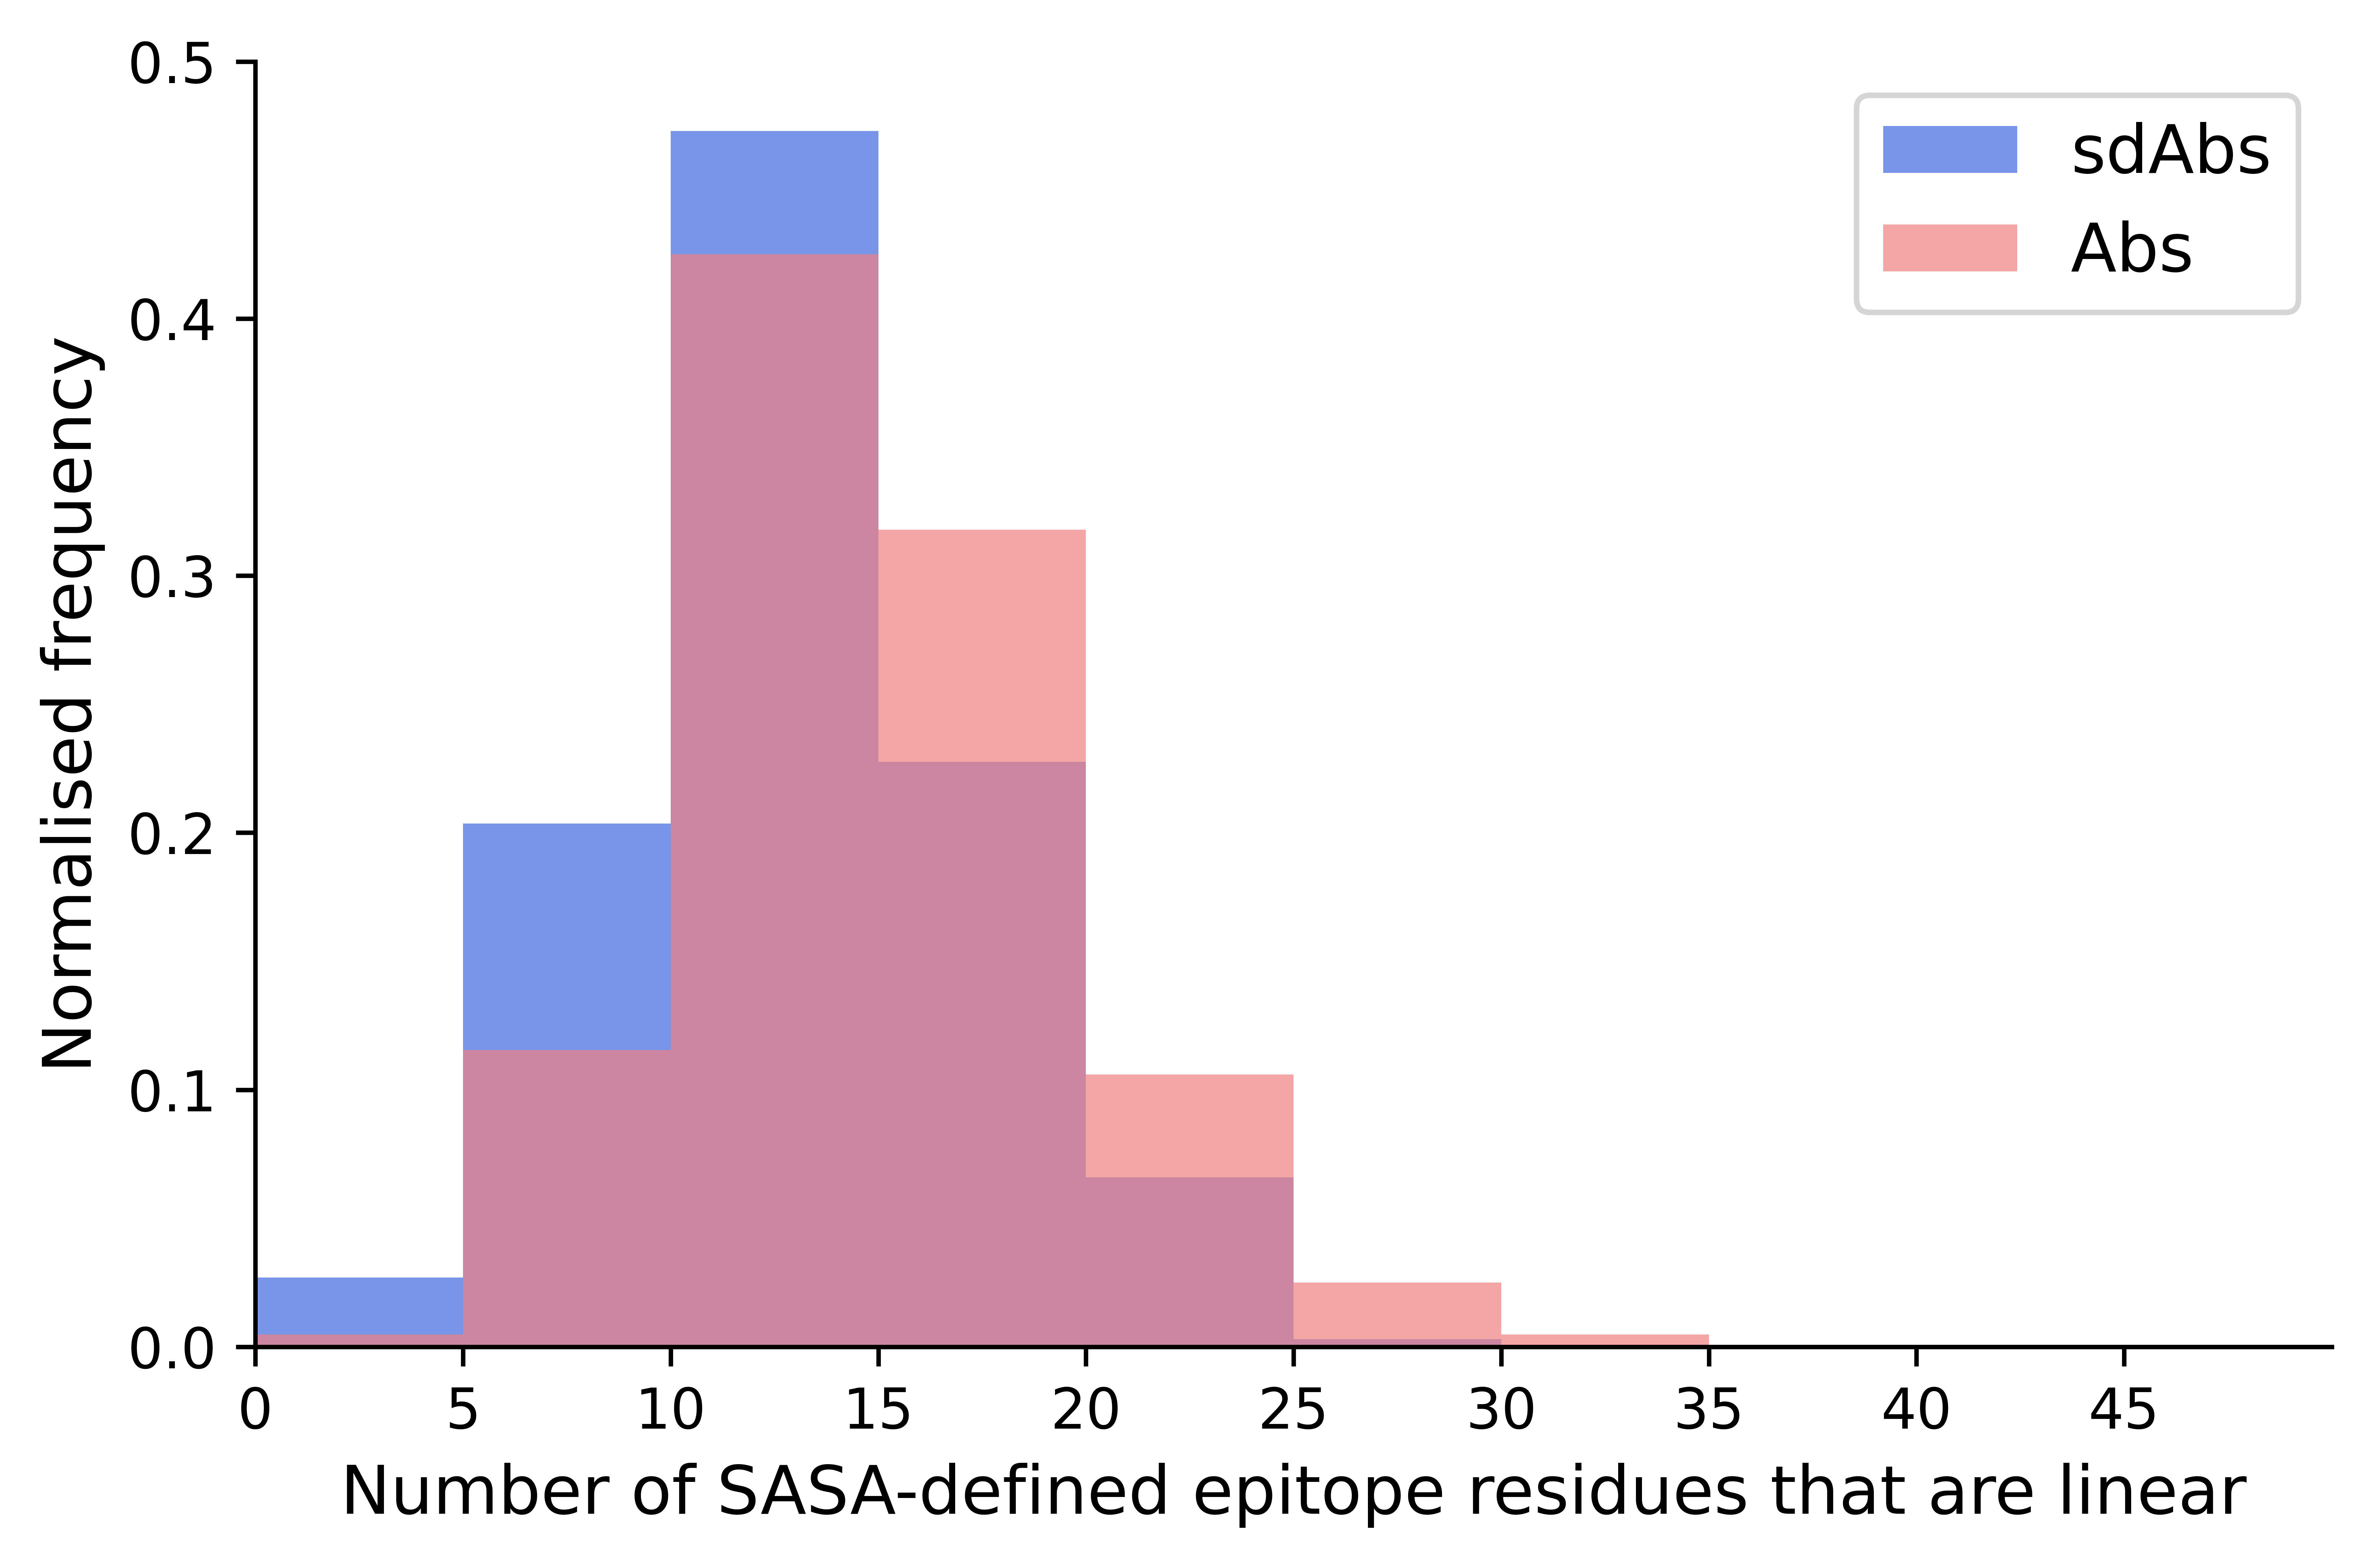

In [19]:

plt.figure()
plt.hist(sdabs_scores_count, bins=range(0,50,5), label='sdAbs', alpha=0.7, color='royalblue', weights=np.zeros_like(sdabs_scores_count) + 1. / len(sdabs_scores_count))
plt.hist(abs_scores_count, bins=range(0,50,5), label='Abs', alpha=0.7, color='lightcoral', weights=np.zeros_like(abs_scores_count) + 1. / len(abs_scores_count))
plt.xlabel('Number of SASA-defined epitope residues that are linear', fontsize=12)
plt.ylabel('Normalised frequency', fontsize=12)
plt.xlim(0, 50, 5)
plt.ylim(0, 0.5)
plt.xticks(range(0, 50, 5))
plt.legend(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [80]:
zoutput_count = ztest(sdabs_scores_count, abs_scores_count, value=0) 
print(f"ztest continuity count: {zoutput_count}")
dict_lengths_count = {'Nbs': sdabs_scores_count,
                     'Abs': abs_scores_count }
perform_bootstrap(300, dict_lengths_count)

ztest continuity count: (-6.517145404604665, 7.165795732460178e-11)
DABEST v0.3.1
             
Good afternoon!
The current time is Mon Apr  3 16:33:23 2023.

The unpaired mean difference between Nbs and Abs is 1.56 [95%CI 0.853, 2.28].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`
